# 2.6장 사이킷런으로 수행하는 타이타닉 생존자 예측

In [3]:
#데이터 분석 시작
#판다스의 read_csv()를 이용해 DataFrame으로 로딩
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

titanic_df = pd.read_csv(r'C:\Users\82102\Downloads\titanic_train.csv')
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
#로딩된 데이터 칼럼 확인 - DataFrame의 info() 메서드 이용
print('\n ### 학습 데이터 정보 ### \n')
print(titanic_df.info())


 ### 학습 데이터 정보 ### 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [6]:
#Null 값 처리 결정: 사이킷런 머신러닝 알고리즘은 Null 값을 허용x
#DataFrame의 fillna() 함수 사용 --> Null 값을 평균 또는 고정 값으로 변경
# Age -> 평균 나이, 나머지 칼럼 -> 'N'

titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace = True)
titanic_df['Cabin'].fillna('N',inplace = True)
titanic_df['Embarked'].fillna('N', inplace = True)
print('데이터 세트 Null 값 개수', titanic_df.isnull().sum().sum())

데이터 세트 Null 값 개수 0


In [7]:
#남아있는 문자열 피처의 값 분류 살펴보기
print('Sex 값 분포 :\n', titanic_df['Sex'].value_counts())
print('Cabin 값 분포 :\n', titanic_df['Cabin'].value_counts())
print('Embarked 값 분포 :\n', titanic_df['Embarked'].value_counts())

Sex 값 분포 :
 male      577
female    314
Name: Sex, dtype: int64
Cabin 값 분포 :
 N              687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: Cabin, Length: 148, dtype: int64
Embarked 값 분포 :
 S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


In [8]:
#Cabin 속성 앞 문자만 추출
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]
print(titanic_df['Cabin'].head(3))

0    N
1    C
2    N
Name: Cabin, dtype: object


In [9]:
#성별에 따른 생존자 수 비교
titanic_df.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

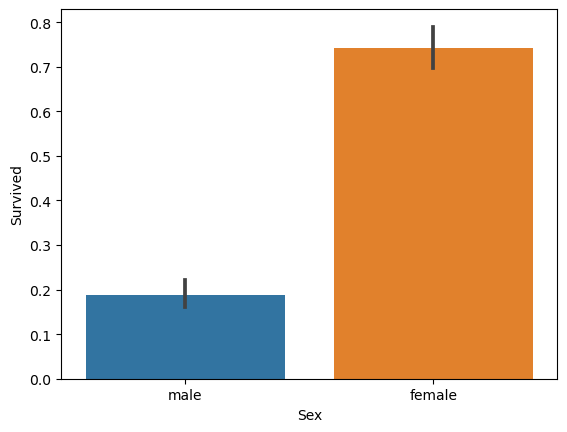

In [11]:
#시본 패키지를 이용한 시각화
sns.barplot(x='Sex', y='Survived', data=titanic_df)

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

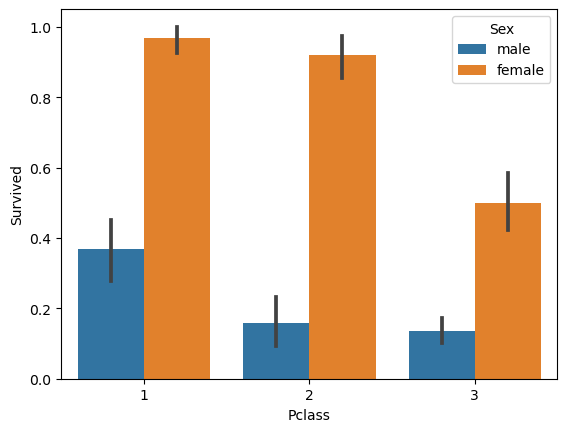

In [12]:
#객실 등급별 성별에 따른 생존 확률
sns.barplot(x='Pclass', y ='Survived', hue='Sex', data=titanic_df)

In [14]:
#Age에 따른 생존 확률
#입력 age에 따라 구분 값을 반환하는 함수 설정. DataFrame의 apply lambda 식에 이용
def get_category(age):
    cat =''
    if age <= -1: cat = 'Unknown'
    elif age <= 5: cat = 'Baby'
    elif age <= 12: cat = 'Child'
    elif age <= 18: cat = 'Teenager'
    elif age <= 25: cat = 'Student'
    elif age <= 35: cat = 'Young Adult'
    elif age <= 60: cat = 'Adult'
    else : cat = 'Ederly'
        
    return cat

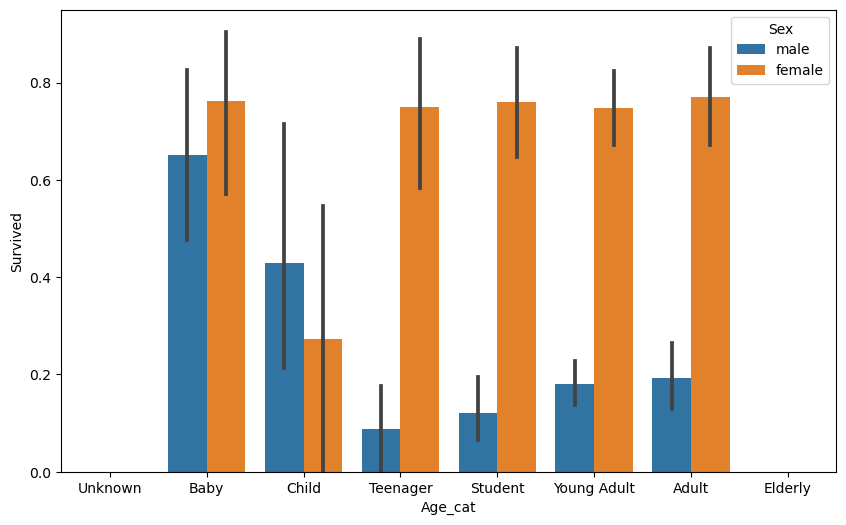

In [16]:
#막대그래프의 크기 figure를 더 크게 설정
plt.figure(figsize=(10,6))

#X축의 값을 순찾거으로 표시하기 위한 설정
group_names = ['Unknown','Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly' ]

#lambda 식에 위에서 생성한 get_category() 함수를 반환값으로 지정.
#get_category(X)는 입력값으로 'Age' 칼럼 값을 받아서 해당하는 cat 반환
titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x:get_category(x))
sns.barplot(x='Age_cat', y='Survived', hue='Sex', data = titanic_df, order=group_names)
titanic_df.drop('Age_cat', axis=1, inplace=True)

In [22]:
#남아있는 문자열 카테고리 피처를 숫자형 카테고리 피처로 변환
#인코딩은 사이킷런의 LabelEncoder 클래스 이용
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

def encode_features(dataDF):
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(dataDF[feature])
        dataDF[feature] = le.transform(dataDF[feature])
        
    return dataDF

titanic_df = encode_features(titanic_df)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,147,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,81,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,147,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,55,2
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,147,2


In [23]:
#Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace = True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

#머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

#레이블 인코딩 수행.
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

#앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [24]:
#원본 데이터를 재로딩하고, 피처 데이터 세트와 레이블 데이터 세트 추출.
titanic_df = pd.read_csv(r'C:\Users\82102\Downloads\titanic_train.csv')
y_titanic_df  = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)

X_titanic_df = transform_features(X_titanic_df)

In [26]:
#학습 데이터 세트를 기반으로 해서 train_test_split() API를 이용해 별도의 테스트 데이터 세트를 추출. 
#테스트 데이터 세트 크기를 전체의 20%
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

In [29]:
#결정 트리, 랜덤 포레스트, 로지스틱 회귀를 이용한 타이타닉 생존자 예측
#사이킷런- 결정트리: DecisonTreeClassifier, 랜덤 포레스트: RandomForestClassifer, 로지스틱 회귀:LogisticRegresstion 클래스 제공
#머신러닝 모델 학습(fit), 예측(preditct)
#예측 성능 평가: 정확도 API: accuracy_score()

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#결정트리, Random Forest, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression()

#DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))

#RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도:{0:.4f}'.format(accuracy_score(y_test, rf_pred)))

#LogisticRegression 학습/예측/평가
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
print('LogisticRegression 정확도: {0:.4f}'.format(accuracy_score(y_test, lr_pred)))

DecisionTreeClassifier 정확도: 0.7877
RandomForestClassifier 정확도:0.8547
LogisticRegression 정확도: 0.8492


C:\Users\82102\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
from sklearn.model_selection import KFold

def exec_kfold(clf, folds=5):
    #폴드 세트를 5개인 KFold객체를 생성, 폴드 수만큼 예측결과 저장을 위한 리스트 객체 생성.
    kfold = KFold(n_splits=folds)
    scores = []
    
    #KFold 교차 검증 수행.
    for iter_count, (train_index, test_index) in enumerate(kfold.split(X_titanic_df)):
        #X_titanic_df 데이터에서 교차 검증별로 학습과 검정 데이터를 가리키는 index 생성
        X_train, X_test = X_titanic_df.values[train_index], X_titanic_df.values[test_index]
        y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]
        
        #Classifier 학습, 예측, 정확도 계산
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        scores.append(accuracy)
        print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))
        
        
    #5개 fold에서의 평균 정확도 계산
    mean_score = np.mean(scores)
    print("평균 정확도: {0:.4f}".format(mean_score))
    
#exec_kfold 호출
exec_kfold(dt_clf, folds=5)

교차 검증 0 정확도: 0.7542
교차 검증 1 정확도: 0.7809
교차 검증 2 정확도: 0.7865
교차 검증 3 정확도: 0.7697
교차 검증 4 정확도: 0.8202
평균 정확도: 0.7823


In [32]:
#교차검증: cross_val_score() API
from sklearn.model_selection import cross_val_score

scores=cross_val_score(dt_clf, X_titanic_df, y_titanic_df, cv=5)
for iter_count, accuracy in enumerate(scores):
    print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))
    
print("평균 정확도: {0:.4f}".format(np.mean(scores)))

교차 검증 0 정확도: 0.7430
교차 검증 1 정확도: 0.7753
교차 검증 2 정확도: 0.7921
교차 검증 3 정확도: 0.7865
교차 검증 4 정확도: 0.8427
평균 정확도: 0.7879


In [35]:
#GridSearchCV를 이용해 DecisionTreeClassifier 최적 하이퍼 파라미터를 찾고 예측 성능 측정

from sklearn.model_selection import GridSearchCV

parameters = {'max_depth': [2, 3, 5, 10],
             'min_samples_split': [2, 3, 5], 'min_samples_leaf': [1, 5, 8]}

grid_dclf = GridSearchCV(dt_clf, param_grid = parameters, scoring='accuracy', cv=5)
grid_dclf.fit(X_train, y_train)

print('GridSearchCV 최적 하이퍼 파라미터 :', grid_dclf.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

#GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행.
dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, dpredictions)
print('테스트 세트에서의 DecisionTreeClassifier 정확도 : {0:.4f}'.format(accuracy))

GridSearchCV 최적 하이퍼 파라미터 : {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.7992
테스트 세트에서의 DecisionTreeClassifier 정확도 : 0.8715


# 3-6. 피마 인디언 당뇨병 예측

In [38]:
#diabetes.csv를 DataFrame으로 로딩

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv(r'C:\Users\82102\Downloads\diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [41]:
#feature의  타입과 Null 개수 살펴보기 -info() 메서드
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [63]:
# 수정된 get_clf_eval() 함수 
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [64]:
def precision_recall_curve_plot(y_test=None, pred_proba_c1=None):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

In [65]:
#로지스틱 회귀를 이용해 예측 모델 생성

# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출. 
# 맨 끝이 Outcome 컬럼으로 레이블 값임. 컬럼 위치 -1을 이용해 추출 
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습,예측 및 평가 수행. 
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test , pred, pred_proba)

오차 행렬
[[87 13]
 [22 32]]
정확도: 0.7727, 정밀도: 0.7111, 재현율: 0.5926,    F1: 0.6465, AUC:0.8083


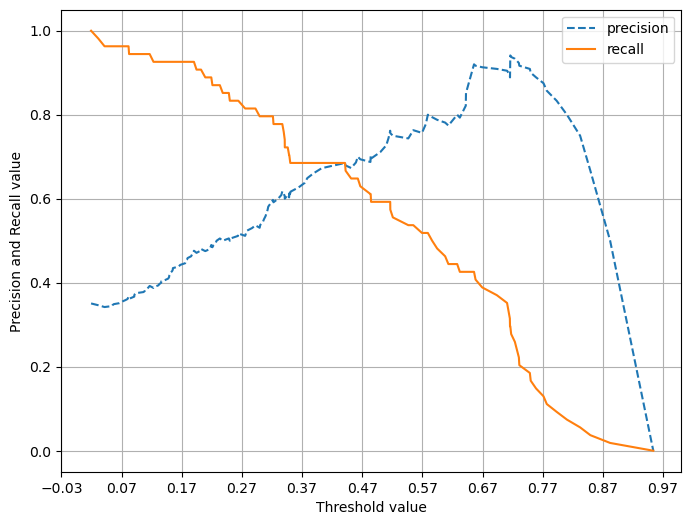

In [67]:
#precision recall 곡선 그림
pred_proba_c1 = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_c1)

In [68]:
#각 피처들의 분포 확인
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <BarContainer object of 10 artists>)

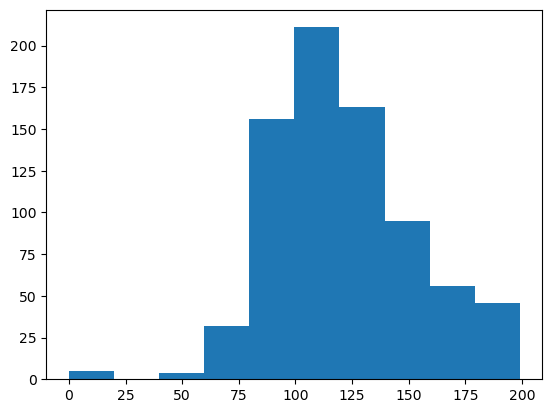

In [69]:
#Glucose 피처의 분포도

plt.hist(diabetes_data['Glucose'], bins=10)

In [70]:
# 0값을 검사할 피처명 리스트 객체 설정
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별로 반복 하면서 데이터 값이 0 인 데이터 건수 추출하고, 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %


In [71]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균 값으로 대체
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, diabetes_data[zero_features].mean())

In [72]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler( )
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행. 
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test , pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,    F1: 0.6804, AUC:0.8433


In [74]:
from sklearn.preprocessing import Binarizer

def get_eval_by_threshold(y_test , pred_proba_c1, thresholds):
    # thresholds 리스트 객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        get_clf_eval(y_test , custom_predict, pred_proba_c1)

In [75]:
thresholds = [0.3 , 0.33 ,0.36,0.39, 0.42 , 0.45 ,0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds )

임곗값: 0.3
오차 행렬
[[65 35]
 [11 43]]
정확도: 0.7013, 정밀도: 0.5513, 재현율: 0.7963,    F1: 0.6515, AUC:0.8433
임곗값: 0.33
오차 행렬
[[71 29]
 [11 43]]
정확도: 0.7403, 정밀도: 0.5972, 재현율: 0.7963,    F1: 0.6825, AUC:0.8433
임곗값: 0.36
오차 행렬
[[76 24]
 [15 39]]
정확도: 0.7468, 정밀도: 0.6190, 재현율: 0.7222,    F1: 0.6667, AUC:0.8433
임곗값: 0.39
오차 행렬
[[78 22]
 [16 38]]
정확도: 0.7532, 정밀도: 0.6333, 재현율: 0.7037,    F1: 0.6667, AUC:0.8433
임곗값: 0.42
오차 행렬
[[84 16]
 [18 36]]
정확도: 0.7792, 정밀도: 0.6923, 재현율: 0.6667,    F1: 0.6792, AUC:0.8433
임곗값: 0.45
오차 행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 정밀도: 0.7059, 재현율: 0.6667,    F1: 0.6857, AUC:0.8433
임곗값: 0.48
오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481,    F1: 0.6931, AUC:0.8433
임곗값: 0.5
오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,    F1: 0.6804, AUC:0.8433


In [76]:
# 임곗값를 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)

# 위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 컬럼값을 Binarizer변환. 
pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1,1)) 

get_clf_eval(y_test , pred_th_048, pred_proba[:, 1])

오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481,    F1: 0.6931, AUC:0.8433
